<a href="https://colab.research.google.com/github/cecnordb/DML_LAsegmentation/blob/main/model_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

cecilianordberg_task2_heart_path = kagglehub.dataset_download('cecilianordberg/task2-heart')
cecilianordberg_model_results_path = kagglehub.dataset_download('cecilianordberg/model-results')
cecilianordberg_scripts_albin_path = kagglehub.dataset_download('cecilianordberg/scripts-albin')

print('Data source import complete.')


100%|██████████| 458M/458M [00:08<00:00, 55.4MB/s]

Extracting files...


100%|██████████| 563M/563M [00:04<00:00, 123MB/s]

Extracting files...


100%|██████████| 167k/167k [00:00<00:00, 49.9MB/s]

Extracting files...
Data source import complete.


In [3]:
model_path =  "/kaggle/input/model-results/model_results"

In [4]:
import torch.nn as nn
import torch

def dice_coefficient(pred, target, smooth=1.):
    pred = pred > 0.5  # Thresholding to get binary predictions
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def soft_dice_coefficient(pred, target, smooth=1.):
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def soft_dice_loss(pred, target, smooth=1.):
    return 1 - soft_dice_coefficient(pred, target, smooth)

def soft_iou(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def iou(pred, target, smooth=1e-6):
    pred = pred > 0.5  # Thresholding to get binary predictions
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

class CombinedLoss(nn.Module):
    """
    Expects logit inputs
    """

    def __init__(self, smooth=1, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.smooth = smooth
        self.dice_weight = dice_weight

    def forward(self, outputs, targets):
        ce_loss = self.bce_loss(outputs, targets)
        dice = soft_dice_loss(torch.sigmoid(outputs), targets, self.smooth)
        return dice * self.dice_weight + ce_loss * (1 - self.dice_weight)

In [5]:
from collections import defaultdict
from time import time
#from scripts.utils import iou, dice_coefficient
import torch
import torch.nn.functional as F


def train_epoch(model, optimizer, loss_fn, train_loader, scheduler, device):
    model.train()
    train_loss = AccumulatingMetric()
    train_iou = AccumulatingMetric()
    train_dice = AccumulatingMetric()
    for batch in train_loader:
        input, target = batch
        # Concatenate the patches along the batch dimension
        input = input.view(-1, *input.shape[2:])
        target = target.view(-1, *target.shape[2:])

        input, target = input.to(device), target.to(device).float()
        optimizer.zero_grad()
        pred_logits = model(input)
        pred_logits = pred_logits.squeeze(1)
        loss = loss_fn(pred_logits, target)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        pred = torch.sigmoid(pred_logits)
        train_loss.add(loss.item())
        train_iou.add(iou(pred, target).cpu().item())
        train_dice.add(dice_coefficient(pred, target).cpu().item())

    return train_loss.avg(), train_iou.avg(), train_dice.avg()

def validate(model, loss_fn, val_loader, device, patch_size):
    model.eval()
    validation_loss = AccumulatingMetric()
    validation_iou = AccumulatingMetric()
    validation_dice = AccumulatingMetric()

    for batch in val_loader:
        # Here I need to separate the input into patches and then merge them after they have all been analyzed. Should I do this with overlap? Yes I should.
        input, target = batch
        input, target = input.to(device), target.to(device).float()
        with torch.no_grad():
            pred_logits = patched_forward(model, input, patch_size, device)
        pred_logits = pred_logits.squeeze(1)
        pred = torch.sigmoid(pred_logits)
        # Calculate the loss, iou and dice coefficient
        loss = loss_fn(pred_logits, target)

        validation_loss.add(loss.item())
        validation_iou.add(iou(pred, target).cpu().item())
        validation_dice.add(dice_coefficient(pred, target).cpu().item())

    return validation_loss.avg(), validation_iou.avg(), validation_dice.avg()

def patched_forward(model, input, patch_size, device, overlap=0.5):
    # This function will take an input image and split it into patches, then run the model on each patch and merge the results.
    batch_size, channels, z, y, x = input.shape
    pz, py, px = patch_size
    stride_z, stride_y, stride_x = int(pz * (1 - overlap)), int(py * (1 - overlap)), int(px * (1 - overlap))

    # Calculate needed padding
    pad_z = (pz - z % pz) if z % pz != 0 else 0
    pad_y = (py - y % py) if y % py != 0 else 0
    pad_x = (px - x % px) if x % px != 0 else 0
    input_padded = F.pad(input, (0, pad_x, 0, pad_y, 0, pad_z))
    padded_z, padded_y, padded_x = input_padded.shape[2:]

    output = torch.zeros((batch_size, channels, padded_z, padded_y, padded_x)).to(device)
    weight_map = torch.zeros((batch_size, channels, padded_z, padded_y, padded_x)).to(device)

    for z_start in range(0, padded_z - pz + 1, stride_z):
        for y_start in range(0, padded_y - py + 1, stride_y):
            for x_start in range(0, padded_x - px + 1, stride_x):
                z_end, y_end, x_end = z_start + pz, y_start + py, x_start + px

                patch = input_padded[:, :, z_start:z_end, y_start:y_end, x_start:x_end]
                patch_output = model(patch)
                # Add the output of the patch to the combined output
                output[:, :, z_start:z_end, y_start:y_end, x_start:x_end] += patch_output

                # Keep track of how many values has been added to each region so that we can average them later
                weight_map[:, :, z_start:z_end, y_start:y_end, x_start:x_end] += 1

    # Avoid division by zero in case some areas are not covered by patches
    weight_map = torch.where(weight_map == 0, torch.ones_like(weight_map), weight_map)

    output /= weight_map

    # Remove padding
    output = output[:, :, :z, :y, :x]
    return output


def train(model, optimizer, loss_fn, train_loader, val_loader, scheduler, device, epochs, patch_size, validation_freq=1):
    print(f"Starting training on device {device}...")
    model.to(device)
    train_metrics = defaultdict(list)
    val_metrics = defaultdict(list)

    best_val_loss = float('inf')  # To store the best validation loss
    best_model_state = None       # To store the best model state

    for epoch in range(epochs):
        start_time = time()
        # Training step
        train_loss, train_iou, train_dice = train_epoch(model, optimizer, loss_fn, train_loader, scheduler, device)
        train_metrics["loss"].append(train_loss)
        train_metrics["iou"].append(train_iou)
        train_metrics["dice"].append(train_dice)
        print(f"Epoch {epoch + 1} of {epochs} took {time() - start_time:.2f}s | Training: loss={train_loss:.4f}, iou={train_iou:.4f}, dice={train_dice:.4f}")

        # Validation step
        if epoch % validation_freq == validation_freq - 1 or epoch == epochs - 1:
            val_loss, val_iou, val_dice = validate(model, loss_fn, val_loader, device, patch_size)
            val_metrics["loss"].append(val_loss)
            val_metrics["iou"].append(val_iou)
            val_metrics["dice"].append(val_dice)
            print(f"Validation: loss={val_loss:.4f}, iou={val_iou:.4f}, dice={val_dice:.4f}")

            # Save the best model based on validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()  # Save the model state
                print(f"New best model found with validation loss {val_loss:.4f}, saving model...")

    model.load_state_dict(best_model_state)
    return model, train_metrics, val_metrics


class AccumulatingMetric:
    """Accumulate samples of a metric and automatically keep track of the number of samples."""

    def __init__(self):
        self.metric = 0.0
        self.counter = 0

    def add(self, value):
        self.metric += value
        self.counter += 1

    def avg(self):
        return self.metric / self.counter

In [6]:
import torch.nn as nn
import torch
from typing import List
from enum import Enum

class NormalizationType(Enum):
    BATCH_NORM = "batch_norm"
    GROUP_NORM = "group_norm"
    NONE = "none"

class MultiConv3d(nn.Module):
    def __init__(self, channels:List = None, normalization:NormalizationType = NormalizationType.BATCH_NORM) -> None:
        super(MultiConv3d, self).__init__()
        layers = []
        for in_channels, out_channels in zip(channels[:-1], channels[1:]):
            layers.append(nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, stride=1))
            if normalization == NormalizationType.BATCH_NORM:
                layers.append(nn.BatchNorm3d(out_channels))
            elif normalization == NormalizationType.GROUP_NORM:
                num_groups = min(16, out_channels // 4)
                layers.append(nn.GroupNorm(num_groups, out_channels))
            layers.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels, features=None, normalization:NormalizationType = NormalizationType.BATCH_NORM) -> None:
        super(UNet3D, self).__init__()
        if features == None:
            features = [32, 64, 128, 256]

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.encoder.append(MultiConv3d([in_channels, feature, feature], normalization))
            in_channels = feature

        # Decoder
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose3d(feature*2, feature, kernel_size=2, stride=2))
            self.decoder.append(MultiConv3d([feature*2, feature, feature], normalization))

        # Bottleneck
        self.bottleneck = MultiConv3d([features[-1], features[-1]*2, features[-1]*2], normalization)

        # Output
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []


        # Encoding
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoding
        skip_connections = reversed(skip_connections)
        for skip_connection, trans_conv, multiconv in zip(skip_connections, self.decoder[0::2], self.decoder[1::2]):
            x = trans_conv(x)
            if x.shape != skip_connection.shape:
                x = self._pad_if_needed(x, skip_connection)

            # Concatenate along channels
            x = torch.cat((skip_connection, x), dim=1)
            x = multiconv(x)

        return self.final_conv(x)

    def _pad_if_needed(self, x, skip_connection):
        """Handle padding issues in case feature maps have different shapes"""
        diff_depth = skip_connection.size(2) - x.size(2)
        diff_height = skip_connection.size(3) - x.size(3)
        diff_width = skip_connection.size(4) - x.size(4)
        x = nn.functional.pad(x, [diff_width // 2, diff_width - diff_width // 2,
                                  diff_height // 2, diff_height - diff_height // 2,
                                  diff_depth // 2, diff_depth - diff_depth // 2])
        return x

In [7]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.8 MB/s eta 0:00:00


In [10]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 15.2 MB/s eta 0:00:00


In [11]:
import torch
from glob import glob
from torch.utils.data import Dataset
import SimpleITK as sitk
import numpy as np
from monai.transforms import ScaleIntensity

class TrainDataset(Dataset):
    """
    require_target = True => all returned patches contain atleast some of the target
    preoad_all_images = True => all images are loaded into memory at the start
    """

    def __init__(self, data_dir, labels_dir, patch_size, require_target=0, transform=None, scale_intensity=False, preload_all_images=True, num_patches_per_image=1):
        self.patch_size = patch_size
        self.transform = transform
        self.scale_intensity = ScaleIntensity(minv=0, maxv=1) if scale_intensity else None
        self.require_target = float(require_target)

        self.data_paths = sorted(glob(data_dir + '/*.nii'))
        self.label_paths = sorted(glob(labels_dir + '/*.nii'))

        self.preload_all_images = preload_all_images
        if preload_all_images:
            self.data = {path_: sitk.GetArrayFromImage(sitk.ReadImage(path_)).astype('float32') for path_ in self.data_paths}
            self.labels = {path_: sitk.GetArrayFromImage(sitk.ReadImage(path_)).astype('int64') for path_ in self.label_paths}
            self.bounding_boxes = {path_: self.compute_bounding_box(self.labels[path_]) for path_ in self.label_paths}

        self.num_patches_per_image = num_patches_per_image

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        if self.preload_all_images:
            image_np = self.data[self.data_paths[idx]]
            label_np = self.labels[self.label_paths[idx]]
            bounding_box = self.bounding_boxes[self.label_paths[idx]]
        else:
            image  = sitk.ReadImage(self.data_paths[idx])
            label = sitk.ReadImage(self.label_paths[idx])

            image_np = sitk.GetArrayFromImage(image).astype('float32')
            label_np = sitk.GetArrayFromImage(label).astype('int64')
            bounding_box = None

        image_tensor = torch.tensor(image_np, dtype=torch.float32)
        label_tensor = torch.tensor(label_np, dtype=torch.float32)

        if self.scale_intensity is not None:
            image_tensor = self.scale_intensity(image_tensor)

        patches = []
        labels = []
        for _ in range(self.num_patches_per_image):
            if torch.rand(1).item() < self.require_target:
                image_patch, label_patch = self.random_crop_3d_target(image_tensor, label_tensor, self.patch_size, bounding_box)
            else:
                image_patch, label_patch = self.random_crop_3d(image_tensor, label_tensor, self.patch_size)

            if self.transform:
                transform_dict = {"image": image_patch, "label": label_patch}
                transformed = self.transform(transform_dict)
                image_patch, label_patch = transformed["image"], transformed["label"]

            image_patch = image_patch.unsqueeze(0)
            patches.append(image_patch)
            labels.append(label_patch)

        return torch.stack(patches, dim=0), torch.stack(labels, dim=0)

    def random_crop_3d(self, image, label, patch_size):
        z, y, x = image.shape
        pz, py, px = patch_size
        sz = torch.randint(0, z - pz, (1,)).item()
        sy = torch.randint(0, y - py, (1,)).item()
        sx = torch.randint(0, x - px, (1,)).item()
        return image[sz:sz+pz, sy:sy+py, sx:sx+px], label[sz:sz+pz, sy:sy+py, sx:sx+px]

    def random_crop_3d_target(self, image, label, patch_size, bounding_box=None):
        z, y, x = image.shape
        pz, py, px = patch_size

        if bounding_box is None:
            bounding_box = self.compute_bounding_box(label)

        z_patch_min, y_patch_min, x_patch_min, z_patch_max, y_patch_max, x_patch_max = bounding_box

        sz = torch.randint(z_patch_min, z_patch_max + 1, (1,)).item()
        sy = torch.randint(y_patch_min, y_patch_max + 1, (1,)).item()
        sx = torch.randint(x_patch_min, x_patch_max + 1, (1,)).item()

        return image[sz:sz+pz, sy:sy+py, sx:sx+px], label[sz:sz+pz, sy:sy+py, sx:sx+px]

    def compute_bounding_box(self, label):
        ones_indices = np.argwhere(label)
        z_min, y_min, x_min = ones_indices.min(axis=0)
        z_max, y_max, x_max = ones_indices.max(axis=0)

        z_patch_min, y_patch_min, x_patch_min = max(0, z_min - self.patch_size[0]), max(0, y_min - self.patch_size[1]), max(0, x_min - self.patch_size[2])
        z_patch_max, y_patch_max, x_patch_max = min(label.shape[0] - self.patch_size[0], z_max), min(label.shape[1] - self.patch_size[1], y_max), min(label.shape[2] - self.patch_size[2], x_max)

        return z_patch_min, y_patch_min, x_patch_min, z_patch_max, y_patch_max, x_patch_max


    # TODO add intensity scaling to the constructor here

class TestDataset(Dataset):
    """
    Test dataset loads the entire image
    """
    def __init__(self, data_dir, labels_dir=None, transform=None, scale_intensity=False):
        self.transform = transform
        self.scale_intensity = ScaleIntensity(minv=0, maxv=1) if scale_intensity else None

        self.data_paths = sorted(glob(data_dir + '/*'))
        self.label_paths = sorted(glob(labels_dir + '/*')) if labels_dir is not None else None

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, index):
        image = sitk.ReadImage(self.data_paths[index])
        image_np = sitk.GetArrayFromImage(image).astype('float32')

        if self.label_paths is not None:
            label = sitk.ReadImage(self.label_paths[index])
            label_np = sitk.GetArrayFromImage(label).astype('int64')
        else:
            label_np = None

        image_tensor = torch.tensor(image_np, dtype=torch.float32).unsqueeze(0)

        if self.scale_intensity is not None:
            image_tensor = self.scale_intensity(image_tensor)

        if self.transform:
            image_tensor = self.transform(image_tensor)

        if label_np is not None:
            label_tensor = torch.tensor(label_np, dtype=torch.int64)
            return image_tensor, label_tensor
        else:
            return image_tensor


In [12]:
#from train import train, validate, patched_forward
#from utils import CombinedLoss
#from models.unet import UNet3D, NormalizationType
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from monai.networks.nets import UNETR, SwinUNETR
from transformers import get_cosine_schedule_with_warmup
#from scripts.dataset import TrainDataset, TestDataset

sns.set_theme(style="whitegrid")
custom_palette = ["#D32F2F", "#1976D2", "#4CAF50"]  # Red, Blue, Light Green
sns.set_palette(custom_palette)

In [13]:
val_image_path = '/kaggle/input/task2-heart/Task02_Heart/Task02_Heart/imagesVl'
val_label_path = '/kaggle/input/task2-heart/Task02_Heart/Task02_Heart/labelsVl'

patch_size = (64, 128, 128)
val_dataset = TestDataset(val_image_path, val_label_path, scale_intensity=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [35]:
import os

# Load UNet3D model results
file_name_unet3d = os.path.join(cecilianordberg_model_results_path, "model_results/unet_model_results.pkl")
with open(file_name_unet3d, 'rb') as f:
    data_unet3d = pickle.load(f)
    best_model_unet3d = UNet3D(in_channels=1, out_channels=1, features=[32, 64, 128, 256], normalization=NormalizationType.GROUP_NORM)
    best_model_unet3d.load_state_dict(data_unet3d['model_state'],strict=False)
    results_unet3d = (best_model_unet3d, data_unet3d['train_metrics'], data_unet3d['val_metrics'])

best_model_unet3d, results_train_unet3d, results_val_unet3d = results_unet3d

# Load UNETR model results
file_name_unetr = os.path.join(cecilianordberg_model_results_path, "model_results/unetR_model_results.pkl")
with open(file_name_unetr, 'rb') as f:
    data_unetr = pickle.load(f)
    best_model_unetr = UNETR(in_channels=1, out_channels=1, img_size=(64, 128, 128))
    best_model_unetr.load_state_dict(data_unetr['model_state'],strict=False)
    results_unetr = (best_model_unetr, data_unetr['train_metrics'], data_unetr['val_metrics'])

best_model_unetr, results_train_unetr, results_val_unetr = results_unetr

# Load SwinUNETR model results
file_name_swinunetr = os.path.join(cecilianordberg_model_results_path, "model_results/swinUnetR_model_results.pkl")
with open(file_name_swinunetr, 'rb') as f:
    data_swinunetr = pickle.load(f)
    best_model_swinunetr = SwinUNETR(in_channels=1, out_channels=1, img_size=(64, 128, 128))
    best_model_swinunetr.load_state_dict(data_swinunetr['model_state'],strict=False)
    results_swinunetr = (best_model_swinunetr, data_swinunetr['train_metrics'], data_swinunetr['val_metrics'])

best_model_swinunetr, results_train_swinunetr, results_val_swinunetr = results_swinunetr

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


In [36]:
results_val_unet3d.keys()

dict_keys(['loss', 'iou', 'dice'])

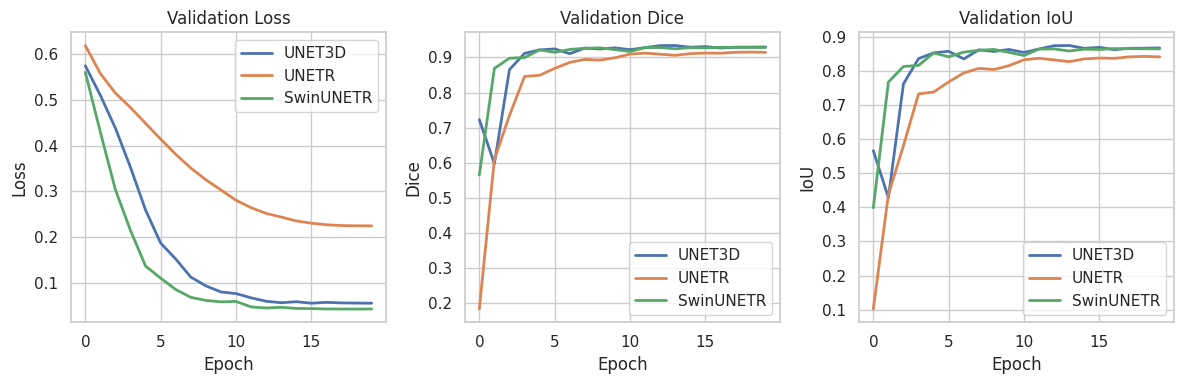

In [37]:
# Create a DataFrame for validation metrics
val_metrics_df = pd.DataFrame({
    'Epoch': range(len(results_val_unet3d['loss'])),
    'UNET3D_Loss': results_val_unet3d['loss'],
    'UNETR_Loss': results_val_unetr['loss'],
    'SwinUNETR_Loss': results_val_swinunetr['loss'],
    'UNET3D_Dice': results_val_unet3d['dice'],
    'UNETR_Dice': results_val_unetr['dice'],
    'SwinUNETR_Dice': results_val_swinunetr['dice'],
    'UNET3D_IoU': results_val_unet3d['iou'],
    'UNETR_IoU': results_val_unetr['iou'],
    'SwinUNETR_IoU': results_val_swinunetr['iou']
})

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot validation loss
sns.lineplot(ax=axes[0], data=val_metrics_df, x='Epoch', y='UNET3D_Loss', label='UNET3D', linewidth=2)
sns.lineplot(ax=axes[0], data=val_metrics_df, x='Epoch', y='UNETR_Loss', label='UNETR', linewidth=2)
sns.lineplot(ax=axes[0], data=val_metrics_df, x='Epoch', y='SwinUNETR_Loss', label='SwinUNETR', linewidth=2)
axes[0].set_title('Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

# Plot validation dice
sns.lineplot(ax=axes[1], data=val_metrics_df, x='Epoch', y='UNET3D_Dice', label='UNET3D', linewidth=2)
sns.lineplot(ax=axes[1], data=val_metrics_df, x='Epoch', y='UNETR_Dice', label='UNETR', linewidth=2)
sns.lineplot(ax=axes[1], data=val_metrics_df, x='Epoch', y='SwinUNETR_Dice', label='SwinUNETR', linewidth=2)
axes[1].set_title('Validation Dice')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice')

# Plot validation IoU
sns.lineplot(ax=axes[2], data=val_metrics_df, x='Epoch', y='UNET3D_IoU', label='UNET3D', linewidth=2)
sns.lineplot(ax=axes[2], data=val_metrics_df, x='Epoch', y='UNETR_IoU', label='UNETR', linewidth=2)
sns.lineplot(ax=axes[2], data=val_metrics_df, x='Epoch', y='SwinUNETR_IoU', label='SwinUNETR', linewidth=2)
axes[2].set_title('Validation IoU')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU')

# Add grid to the plots
for ax in axes:
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

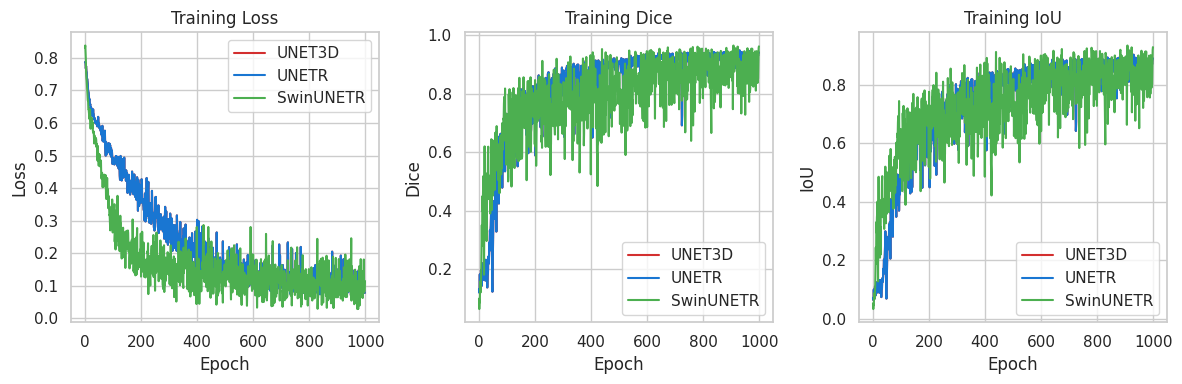

In [30]:
# Create a DataFrame for training metrics
train_metrics_df = pd.DataFrame({
    'Epoch': range(len(results_train_unet3d['loss'])),
    'UNET3D_Loss': results_train_unet3d['loss'],
    'UNETR_Loss': results_train_unetr['loss'],
    'SwinUNETR_Loss': results_train_swinunetr['loss'],
    'UNET3D_Dice': results_train_unet3d['dice'],
    'UNETR_Dice': results_train_unetr['dice'],
    'SwinUNETR_Dice': results_train_swinunetr['dice'],
    'UNET3D_IoU': results_train_unet3d['iou'],
    'UNETR_IoU': results_train_unetr['iou'],
    'SwinUNETR_IoU': results_train_swinunetr['iou']
})

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot training loss
sns.lineplot(ax=axes[0], data=train_metrics_df, x='Epoch', y='UNET3D_Loss', label='UNET3D')
sns.lineplot(ax=axes[0], data=train_metrics_df, x='Epoch', y='UNETR_Loss', label='UNETR')
sns.lineplot(ax=axes[0], data=train_metrics_df, x='Epoch', y='SwinUNETR_Loss', label='SwinUNETR')
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

# Plot training dice
sns.lineplot(ax=axes[1], data=train_metrics_df, x='Epoch', y='UNET3D_Dice', label='UNET3D')
sns.lineplot(ax=axes[1], data=train_metrics_df, x='Epoch', y='UNETR_Dice', label='UNETR')
sns.lineplot(ax=axes[1], data=train_metrics_df, x='Epoch', y='SwinUNETR_Dice', label='SwinUNETR')
axes[1].set_title('Training Dice')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice')

# Plot training IoU
sns.lineplot(ax=axes[2], data=train_metrics_df, x='Epoch', y='UNET3D_IoU', label='UNET3D')
sns.lineplot(ax=axes[2], data=train_metrics_df, x='Epoch', y='UNETR_IoU', label='UNETR')
sns.lineplot(ax=axes[2], data=train_metrics_df, x='Epoch', y='SwinUNETR_IoU', label='SwinUNETR')
axes[2].set_title('Training IoU')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU')


# Add grid to the plots
for ax in axes:
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

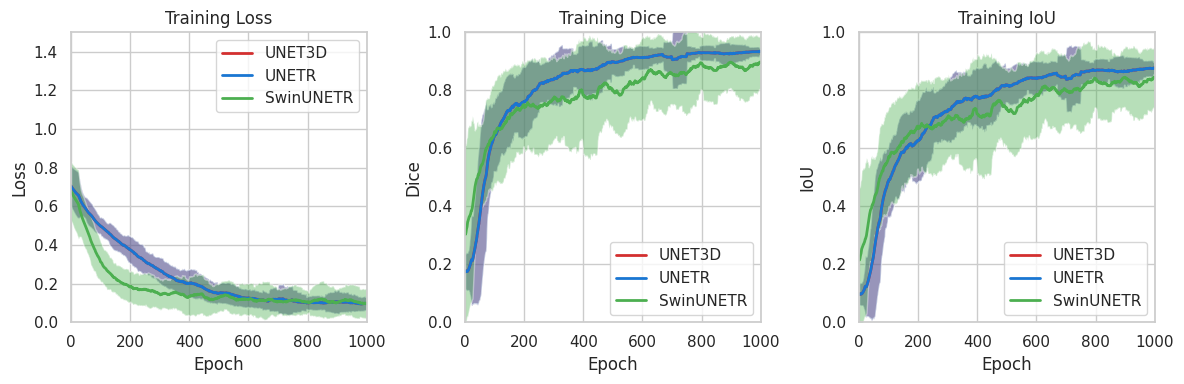

In [31]:
# Calculate rolling mean and standard deviation
window_size = 50
alpha_ = 0.4
line_width = 2  # Parameter to change the line width

train_metrics_df['UNET3D_Loss_Mean'] = train_metrics_df['UNET3D_Loss'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['UNET3D_Loss_Std'] = train_metrics_df['UNET3D_Loss'].rolling(window=window_size, min_periods=1, center=True).std()
train_metrics_df['UNETR_Loss_Mean'] = train_metrics_df['UNETR_Loss'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['UNETR_Loss_Std'] = train_metrics_df['UNETR_Loss'].rolling(window=window_size, min_periods=1, center=True).std()
train_metrics_df['SwinUNETR_Loss_Mean'] = train_metrics_df['SwinUNETR_Loss'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['SwinUNETR_Loss_Std'] = train_metrics_df['SwinUNETR_Loss'].rolling(window=window_size, min_periods=1, center=True).std()

train_metrics_df['UNET3D_Dice_Mean'] = train_metrics_df['UNET3D_Dice'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['UNET3D_Dice_Std'] = train_metrics_df['UNET3D_Dice'].rolling(window=window_size, min_periods=1, center=True).std()
train_metrics_df['UNETR_Dice_Mean'] = train_metrics_df['UNETR_Dice'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['UNETR_Dice_Std'] = train_metrics_df['UNETR_Dice'].rolling(window=window_size, min_periods=1, center=True).std()
train_metrics_df['SwinUNETR_Dice_Mean'] = train_metrics_df['SwinUNETR_Dice'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['SwinUNETR_Dice_Std'] = train_metrics_df['SwinUNETR_Dice'].rolling(window=window_size, min_periods=1, center=True).std()

train_metrics_df['UNET3D_IoU_Mean'] = train_metrics_df['UNET3D_IoU'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['UNET3D_IoU_Std'] = train_metrics_df['UNET3D_IoU'].rolling(window=window_size, min_periods=1, center=True).std()
train_metrics_df['UNETR_IoU_Mean'] = train_metrics_df['UNETR_IoU'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['UNETR_IoU_Std'] = train_metrics_df['UNETR_IoU'].rolling(window=window_size, min_periods=1, center=True).std()
train_metrics_df['SwinUNETR_IoU_Mean'] = train_metrics_df['SwinUNETR_IoU'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['SwinUNETR_IoU_Std'] = train_metrics_df['SwinUNETR_IoU'].rolling(window=window_size, min_periods=1, center=True).std()

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot training loss with confidence intervals
axes[0].plot(train_metrics_df['Epoch'], train_metrics_df['UNET3D_Loss_Mean'], label='UNET3D', linewidth=line_width)
axes[0].fill_between(train_metrics_df['Epoch'],
                     train_metrics_df['UNET3D_Loss_Mean'] - 1.96 * train_metrics_df['UNET3D_Loss_Std'],
                     train_metrics_df['UNET3D_Loss_Mean'] + 1.96 * train_metrics_df['UNET3D_Loss_Std'], alpha=alpha_)
axes[0].plot(train_metrics_df['Epoch'], train_metrics_df['UNETR_Loss_Mean'], label='UNETR', linewidth=line_width)
axes[0].fill_between(train_metrics_df['Epoch'],
                     train_metrics_df['UNETR_Loss_Mean'] - 1.96 * train_metrics_df['UNETR_Loss_Std'],
                     train_metrics_df['UNETR_Loss_Mean'] + 1.96 * train_metrics_df['UNETR_Loss_Std'], alpha=alpha_)
axes[0].plot(train_metrics_df['Epoch'], train_metrics_df['SwinUNETR_Loss_Mean'], label='SwinUNETR', linewidth=line_width)
axes[0].fill_between(train_metrics_df['Epoch'],
                     train_metrics_df['SwinUNETR_Loss_Mean'] - 1.96 * train_metrics_df['SwinUNETR_Loss_Std'],
                     train_metrics_df['SwinUNETR_Loss_Mean'] + 1.96 * train_metrics_df['SwinUNETR_Loss_Std'], alpha=alpha_)
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

# Plot training dice with confidence intervals
axes[1].plot(train_metrics_df['Epoch'], train_metrics_df['UNET3D_Dice_Mean'], label='UNET3D', linewidth=line_width)
axes[1].fill_between(train_metrics_df['Epoch'],
                     train_metrics_df['UNET3D_Dice_Mean'] - 1.96 * train_metrics_df['UNET3D_Dice_Std'],
                     train_metrics_df['UNET3D_Dice_Mean'] + 1.96 * train_metrics_df['UNET3D_Dice_Std'], alpha=alpha_)
axes[1].plot(train_metrics_df['Epoch'], train_metrics_df['UNETR_Dice_Mean'], label='UNETR', linewidth=line_width)
axes[1].fill_between(train_metrics_df['Epoch'],
                     train_metrics_df['UNETR_Dice_Mean'] - 1.96 * train_metrics_df['UNETR_Dice_Std'],
                     train_metrics_df['UNETR_Dice_Mean'] + 1.96 * train_metrics_df['UNETR_Dice_Std'], alpha=alpha_)
axes[1].plot(train_metrics_df['Epoch'], train_metrics_df['SwinUNETR_Dice_Mean'], label='SwinUNETR', linewidth=line_width)
axes[1].fill_between(train_metrics_df['Epoch'],
                     train_metrics_df['SwinUNETR_Dice_Mean'] - 1.96 * train_metrics_df['SwinUNETR_Dice_Std'],
                     train_metrics_df['SwinUNETR_Dice_Mean'] + 1.96 * train_metrics_df['SwinUNETR_Dice_Std'], alpha=alpha_)
axes[1].set_title('Training Dice')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice')

# Plot training IoU with confidence intervals
axes[2].plot(train_metrics_df['Epoch'], train_metrics_df['UNET3D_IoU_Mean'], label='UNET3D', linewidth=line_width)
axes[2].fill_between(train_metrics_df['Epoch'],
                     train_metrics_df['UNET3D_IoU_Mean'] - 1.96 * train_metrics_df['UNET3D_IoU_Std'],
                     train_metrics_df['UNET3D_IoU_Mean'] + 1.96 * train_metrics_df['UNET3D_IoU_Std'], alpha=alpha_)
axes[2].plot(train_metrics_df['Epoch'], train_metrics_df['UNETR_IoU_Mean'], label='UNETR', linewidth=line_width)
axes[2].fill_between(train_metrics_df['Epoch'],
                     train_metrics_df['UNETR_IoU_Mean'] - 1.96 * train_metrics_df['UNETR_IoU_Std'],
                     train_metrics_df['UNETR_IoU_Mean'] + 1.96 * train_metrics_df['UNETR_IoU_Std'], alpha=alpha_)
axes[2].plot(train_metrics_df['Epoch'], train_metrics_df['SwinUNETR_IoU_Mean'], label='SwinUNETR', linewidth=line_width)
axes[2].fill_between(train_metrics_df['Epoch'],
                     train_metrics_df['SwinUNETR_IoU_Mean'] - 1.96 * train_metrics_df['SwinUNETR_IoU_Std'],
                     train_metrics_df['SwinUNETR_IoU_Mean'] + 1.96 * train_metrics_df['SwinUNETR_IoU_Std'], alpha=alpha_)
axes[2].set_title('Training IoU')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU')

# Set seaborn theme
sns.set_theme(style="whitegrid")

# Add grid to the plots
for ax in axes:
    ax.grid(True)
    ax.legend()
    ax.set_xlim(0, 1000)
    if ax == axes[0]:
        ax.set_ylim(0, 1.5)
    else:
        ax.set_ylim(0, 1)

# Adjust layout
plt.tight_layout()
plt.show()